### Dataset Extraction

In [1]:
import zipfile
import os
from itertools import combinations
import pandas as pd

nameset = 'Dataset'
annotators = ['Annotator A', 'Annotator B', 'Annotator C', 'Annotator D']
annotators_idx = [f'{x}' for x in range(0, len(annotators))]
datasets_zip = [f'[{annotator}] {nameset}.zip' for annotator in annotators]

# unzip the uploaded annotation folders
for dataset in datasets_zip:
    with zipfile.ZipFile(os.path.join(nameset, dataset), 'r') as zip_ref:
        dst_folder = dataset[:-4]
        zip_ref.extractall(os.path.join(nameset, dst_folder))
        with open(os.path.join(nameset, dst_folder, "annotations", "instances_default.json"), "r") as source, open(os.path.join(nameset, dst_folder, "annotations.json"), "w") as dst:
            dst.write(source.read())

combi = list(combinations(annotators_idx, 2))
print(combi)
column_title = ['-'.join(x) for x in combi]

column_title.insert(0, 'Filename')
df = pd.DataFrame(columns = column_title)

[('0', '1'), ('0', '2'), ('0', '3'), ('1', '2'), ('1', '3'), ('2', '3')]
['Filename', '0-1', '0-2', '0-3', '1-2', '1-3', '2-3', 'Best Index', 'Best Score']


### Dataset Loading

In [2]:
import torch

from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.config import get_cfg
import detectron2.config
from pycocotools.coco import COCO

import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import csv

In [3]:
#Load the datasets
datasets = [x.split('.')[0] for x in datasets_zip]
dataDirs = []
annFiles = []
metadatas = {}
loaded_datasets = {}
DatasetCatalog.clear()

for dataset in datasets:
    dataDir = os.path.join(nameset, dataset, "images")
    annFile = os.path.join(nameset, dataset, "annotations.json")
    with open(annFile, "r") as read_file:
        annJson = json.load(read_file)
        annFiles.append(annJson)

    register_coco_instances(dataset, {}, annFile, dataDir)
    loaded_datasets[dataset] = DatasetCatalog.get(dataset)
    metadatas[dataset] = MetadataCatalog.get(dataset)

print(loaded_datasets.keys())

dict_keys(["[N] 255's Blanks", "[K] 255's Blanks", "[R] 255's Blanks", "[J] 255's Blanks"])


In [4]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['First', 'Second', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  
  plt.show()

In [5]:
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['image_id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        mask = np.maximum(new_mask, mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    mask = mask.reshape(input_image_size[0], input_image_size[1], 1)
    return mask

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
255's Blanks/[N] 255's Blanks/images/marikinasatellite14.646710592744292_121.10705532806863.png
loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


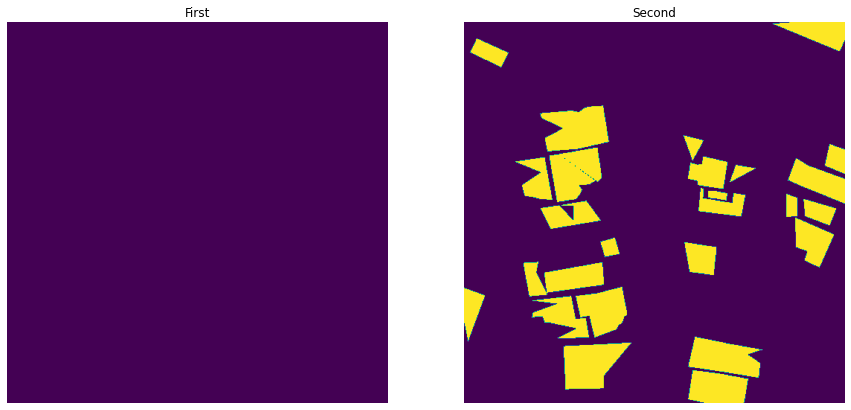

In [6]:
display_list = []
input_size = (512,512)
filenames = []

for dataset in loaded_datasets.keys():
    coco=COCO(metadatas[dataset].get('json_file'))
    catIds = coco.getCatIds(catNms=metadatas[dataset].get('thing_classes'))
    col = []
    for mask in loaded_datasets[dataset]:
        im = cv2.imread(mask["file_name"])
        v = Visualizer(im[:, :, ::-1],
                       metadata=metadatas[dataset], 
                       scale=1.2)
        out = v.draw_dataset_dict(mask)
        col.append(getBinaryMask(mask, coco, catIds[1:] , input_size))
        filenames.append(mask["file_name"])
    display_list.append(col)
        
# display([display_list[0][1], display_list[1][1]])

### IOU Calculation

In [7]:
# PyTroch version
SMOOTH = 1e-6

def IoU(predict: torch.Tensor, target: torch.Tensor):

    i = (predict & target).double().sum()
    u = (predict | target).double().sum()
    x = (i/u)
    IoU = x.item()

    return IoU

df = pd.DataFrame()
for i in range(0, len(display_list[0])):
    IOU_scores = []
    for x in combi:
        ann1_idx = int(x[0])
        ann2_idx = int(x[1])
        iou_score = IoU(torch.Tensor(display_list[ann1_idx][i]).type(torch.IntTensor), 
                        torch.Tensor(display_list[ann2_idx][i]).type(torch.IntTensor))
        if iou_score == 0:
            iou_score = np.nan
        IOU_scores.append(iou_score)

    df_dict = {f'{column_title[x + 1]}': IOU_scores[x] for x in range(0, len(IOU_scores))}
    df_dict['Filename'] = filenames[i].split('/')[3]
    df = df.append(df_dict, ignore_index=True)
    
df

,0-1,0-2,0-3,1-2,1-3,2-3,Filename
0,0.809330,0.825919,0.780204,0.748988,0.741051,0.859752,marikinasatellite14.646710592744292_121.106341...
1,NaN,NaN,NaN,NaN,0.825603,NaN,marikinasatellite14.646710592744292_121.107055...
2,0.860604,0.781486,0.778985,0.823725,0.841188,0.848973,marikinasatellite14.646710592744292_121.107769...
3,0.819168,0.784926,0.767317,0.807614,0.823482,0.820353,marikinasatellite14.646710592744292_121.108482...
4,NaN,NaN,NaN,0.855255,0.875565,0.821910,marikinasatellite14.647401270783632_121.099917...
...,...,...,...,...,...,...,...
68,0.896661,0.782031,0.829251,0.788148,0.851493,0.786714,marikinasatellite14.654308051177042_121.106341...
69,0.824980,0.815299,0.787272,0.809592,0.856158,0.780641,marikinasatellite14.654308051177042_121.107055...
70,0.698895,0.726371,NaN,0.857091,NaN,NaN,marikinasatellite14.654308051177042_121.107769...
71,0.814129,0.822781,0.807139,0.861848,0.842505,0.831295,marikinasatellite14.654308051177042_121.108482...


In [8]:
filtered_df = df.dropna(thresh=3)
filtered_df['avg_score'] = filtered_df.iloc[:,:6].mean(skipna=True, axis=1)
filtered_df

71

In [11]:
for i in np.arange(0.4, 1.0, 0.1):
    print("IoU Threshold: ", i)
    print("No. of images that passed: ", len(filtered_df[filtered_df['avg_score'] > i]))

IoU Threshold:  0.4
No. of images that passed:  71
IoU Threshold:  0.5
No. of images that passed:  70
IoU Threshold:  0.6
No. of images that passed:  70
IoU Threshold:  0.7
No. of images that passed:  65
IoU Threshold:  0.7999999999999999
No. of images that passed:  46
IoU Threshold:  0.8999999999999999
No. of images that passed:  2


In [13]:
filtered_df = filtered_df[filtered_df['avg_score'] > 0.7]
len(filtered_df)

65

### JSON Building

In [15]:
def createAnnotationJSON(annJson):
    # Create a base json where we copy info, licenses, and categories
    baseJson = {}
    baseJson['info'] = annJson['info']
    baseJson['licenses'] = annJson['licenses']
    baseJson['categories'] = annJson['categories']
    baseJson['images'] = []
    baseJson['annotations'] = []
    return baseJson

In [17]:
# Create a base json where we copy info, licenses, and categories
baseJson = createAnnotationJSON(annFiles[0])

In [19]:
from PIL import Image
anno_ctr = 0
img_dir = f'./{nameset}/[{annotators[0]}] {nameset}/images'
output_filename = f'./{nameset}/filtered_images'
os.makedirs(output_filename, exist_ok=True)

for index, row in filtered_df.iterrows():
    baseJson['images'].append({'id': index + 1,
                              'width': 512,
                              'height': 512,
                              'file_name': row['Filename'],
                              'license': 0,
                              'flickr_url': '',
                              'coco_url': '',
                              'date_captured': 0})
    
    #we choose one of the annotator's drawings as the basis
    for image in annFiles[1]['images']:
        if image['file_name'] == row['Filename']:
            img_id = image['id']
            img = Image.open(os.path.join(img_dir, image['file_name'])) 
            img.save(os.path.join(output_filename, image['file_name']))
            break
    
    for annotation in annFiles[1]['annotations']:
        if annotation['image_id'] == img_id:
            annotation['id'] = anno_ctr + 1
            annotation['image_id'] = index + 1
            anno_ctr += 1
            baseJson['annotations'].append(annotation)

In [20]:
len(os.listdir(output_filename))

65

In [21]:
with open(os.path.join('./' + nameset + '/', "annotation.json"), "w") as write_file:
    json.dump(baseJson, write_file)

In [22]:
import shutil

dir_name = './' + nameset + '/filtered_images'
output_filename = './' + nameset + '/filtered_images'

shutil.make_archive(output_filename, 'zip', dir_name)

"/home/jupyter-sinagpala/Old Dataset Runs/dataset/IOU Sampler/255's Blanks/filtered_images.zip"